In [14]:
from jax import grad, jit, vmap, random, lax
import jax
import jax.numpy as jnp

import torch
import torch.nn as nn

import numpy as np

from functools import partial
from dataclasses import dataclass

In [4]:
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

key = random.PRNGKey(0)
x = random.normal(key, (10,))
print(x)

[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [7]:
from jax.tree_util import register_pytree_node_class

@register_pytree_node_class
@dataclass
class LstmParams:
    w_ih: np.ndarray
    w_hh: np.ndarray
    b_ih: np.ndarray
    b_hh: np.ndarray
        
    def tree_flatten(self):
        children = self.w_ih, self.w_hh, self.b_ih, self.b_hh
        aux_data = None
        return children, aux_data
    
    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)

In [11]:
def lstm_model(params, xs, h_0, c_0):
    final_state, output = lax.scan(partial(lstm_step, params), (h_0, c_0), xs)
    return output

def lstm_step(params, state, xs):
    
    h_0, c_0 = state
    
    gates = params.w_ih @ xs + params.b_ih + params.w_hh @ h_0 + params.b_hh
    in_gate, forget_gate, cell_gate, out_gate = jnp.split(gates, 4)
    
    cy = (forget_gate * c_0) + (in_gate * cell_gate)
    hy = out_gate * jax.nn.tanh(cy)
    
    return (hy, cy), hy

In [15]:
%%time
input_size = 128
hidden_size = 128
lstm_model_jit = jit(lstm_model)
lstm_model_jit(
    LstmParams(
        np.zeros((4 * hidden_size, input_size)),
        np.zeros((4 * hidden_size, hidden_size)),
        np.zeros((4 * hidden_size,)),
        np.zeros((4 * hidden_size,)),
    ),
    np.zeros((1000, input_size,)),
    np.zeros((hidden_size,)),
    np.zeros((hidden_size,)),
)

CPU times: user 141 ms, sys: 26.3 ms, total: 167 ms
Wall time: 277 ms


DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [162]:
%%time
print(lstm_model_jit.lower(
    (
        np.zeros((4 * hidden_size, input_size)),
        np.zeros((4 * hidden_size,)),
        np.zeros((4 * hidden_size, hidden_size)),
        np.zeros((4 * hidden_size,)),
    ),
    np.zeros((1000, input_size,)),
    np.zeros((hidden_size,)),
    np.zeros((hidden_size,)),
).as_text())

module @jit_lstm_model.52 {
  func.func public @main(%arg0: tensor<4096x1024xf32>, %arg1: tensor<4096xf32>, %arg2: tensor<4096x1024xf32>, %arg3: tensor<4096xf32>, %arg4: tensor<1000x1024xf32>, %arg5: tensor<1024xf32>, %arg6: tensor<1024xf32>) -> tensor<1000x1024xf32> {
    %0 = mhlo.constant dense<0.000000e+00> : tensor<f32>
    %1 = "mhlo.broadcast_in_dim"(%0) {broadcast_dimensions = dense<> : tensor<0xi64>} : (tensor<f32>) -> tensor<1000x1024xf32>
    %2 = mhlo.constant dense<0> : tensor<i32>
    %3:9 = mhlo.while(%iterArg = %arg4, %iterArg_0 = %arg0, %iterArg_1 = %arg1, %iterArg_2 = %arg2, %iterArg_3 = %arg3, %iterArg_4 = %2, %iterArg_5 = %arg5, %iterArg_6 = %arg6, %iterArg_7 = %1) : tensor<1000x1024xf32>, tensor<4096x1024xf32>, tensor<4096xf32>, tensor<4096x1024xf32>, tensor<4096xf32>, tensor<i32>, tensor<1024xf32>, tensor<1024xf32>, tensor<1000x1024xf32>
     cond {
      %4 = mhlo.constant dense<1000> : tensor<i32>
      %5 = "mhlo.compare"(%iterArg_4, %4) {compare_type = #mhlo<c

In [ ]:
lstm_model_

In [245]:
class CustomLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell = CustomLSTMCell(input_size, hidden_size)
        
    def forward(self, input):
        h, c = torch.zeros(self.hidden_size), torch.zeros(self.hidden_size)
        outputs = []
        for i in range(len(input)):
            h, c = self.cell(input[i], (h, c))
            outputs.append(h)
            
        return outputs, (h, c)

class CustomLSTMCell(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight_ih = torch.nn.Parameter(torch.randn(4 * hidden_size, input_size))
        self.weight_hh = torch.nn.Parameter(torch.randn(4 * hidden_size, hidden_size))
        self.bias_ih = torch.nn.Parameter(torch.randn(4 * hidden_size))
        self.bias_hh = torch.nn.Parameter(torch.randn(4 * hidden_size))

    def forward(self, input, state):
        # type: (Tensor, Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
        hx, cx = state
        gates = (input @ self.weight_ih.t() + self.bias_ih +
                 hx @ self.weight_hh.t() + self.bias_hh)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 0)

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)

        return hy, cy

In [246]:
torch_lstm = CustomLSTM(128, 128)
t = torch.zeros(1000, 128)

In [251]:
%%time
with torch.no_grad():
    torch_lstm(t)

CPU times: user 286 ms, sys: 1.41 ms, total: 287 ms
Wall time: 156 ms


In [ ]:
lax.scan()

In [61]:
np.random.normal(size=(64, 64))

array([[ 0.96589488,  0.30303295,  0.74763393, ..., -0.6795796 ,
         0.06711103,  1.17431941],
       [ 0.70892449,  0.31808199, -0.82909577, ...,  1.20363463,
         0.46466613,  1.98741418],
       [ 0.5813831 ,  0.04676802,  1.58081992, ..., -0.71274007,
        -1.6727985 ,  0.24868153],
       ...,
       [-0.31201267,  0.61315431,  2.16878743, ..., -0.71575788,
        -0.196202  , -0.81780193],
       [ 0.27412789, -2.05271653, -1.15464317, ..., -0.95800908,
        -2.38512656,  0.69364098],
       [-1.34154884, -0.11968709, -1.59875441, ..., -1.50942542,
        -0.49023361,  0.38057436]])

In [64]:
theta = (
    np.random.normal(size=(64, 64)),
    np.random.normal(size=(64,)),
)
xs = np.random.normal(size=(64,))

In [82]:
jax.make_jaxpr(rnn_model)(theta, xs)

{ lambda ; a:f32[64,64] b:f32[64] c:f32[64]. let
    d:f32[64] = dot_general[
      dimension_numbers=(((1,), (0,)), ((), ()))
      precision=None
      preferred_element_type=None
    ] a c
    e:f32[64] = add d b
    f:f32[64] = dot_general[
      dimension_numbers=(((1,), (0,)), ((), ()))
      precision=None
      preferred_element_type=None
    ] a e
    g:f32[64] = add f b
    h:f32[64] = dot_general[
      dimension_numbers=(((1,), (0,)), ((), ()))
      precision=None
      preferred_element_type=None
    ] a g
    i:f32[64] = add h b
    j:f32[64] = dot_general[
      dimension_numbers=(((1,), (0,)), ((), ()))
      precision=None
      preferred_element_type=None
    ] a i
    k:f32[64] = add j b
    l:f32[64] = dot_general[
      dimension_numbers=(((1,), (0,)), ((), ()))
      precision=None
      preferred_element_type=None
    ] a k
    m:f32[64] = add l b
    n:f32[64] = dot_general[
      dimension_numbers=(((1,), (0,)), ((), ()))
      precision=None
      preferred_e

In [79]:
print(jit(rnn_model).lower(theta, xs).as_text())

module @jit_rnn_model.39 {
  func.func public @main(%arg0: tensor<64x64xf32>, %arg1: tensor<64xf32>, %arg2: tensor<64xf32>) -> tensor<64xf32> {
    %0 = "mhlo.dot_general"(%arg0, %arg2) {dot_dimension_numbers = #mhlo.dot<lhs_contracting_dimensions = [1], rhs_contracting_dimensions = [0]>, precision_config = [#mhlo<precision DEFAULT>, #mhlo<precision DEFAULT>]} : (tensor<64x64xf32>, tensor<64xf32>) -> tensor<64xf32>
    %1 = mhlo.add %0, %arg1 : tensor<64xf32>
    %2 = "mhlo.dot_general"(%arg0, %1) {dot_dimension_numbers = #mhlo.dot<lhs_contracting_dimensions = [1], rhs_contracting_dimensions = [0]>, precision_config = [#mhlo<precision DEFAULT>, #mhlo<precision DEFAULT>]} : (tensor<64x64xf32>, tensor<64xf32>) -> tensor<64xf32>
    %3 = mhlo.add %2, %arg1 : tensor<64xf32>
    %4 = "mhlo.dot_general"(%arg0, %3) {dot_dimension_numbers = #mhlo.dot<lhs_contracting_dimensions = [1], rhs_contracting_dimensions = [0]>, precision_config = [#mhlo<precision DEFAULT>, #mhlo<precision DEFAULT>]} : (

In [ ]:
jit(rnn_model).

In [2]:
def model(theta, x):
    """Computes wx + b on a batch of input x."""
    w, b = theta
    return w * x + b

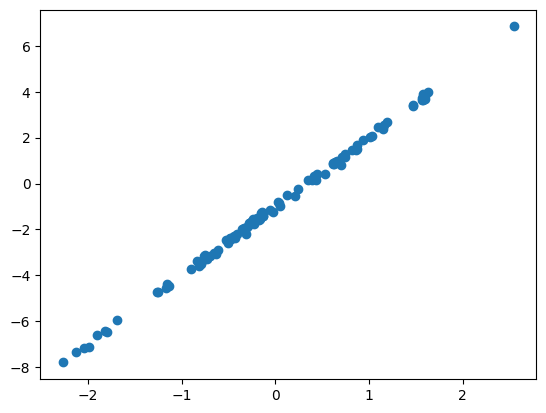

In [3]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

In [4]:
theta = jnp.array([1., 1.])
model(theta, xs)

DeviceArray([ 0.4975571 ,  1.2424994 ,  1.3435951 ,  0.5117413 ,
             -1.0394187 ,  2.4631166 ,  0.16100919, -0.16582906,
              2.0965214 ,  0.8592652 ,  0.5559618 , -0.15341556,
              1.5302485 ,  0.34030586,  0.24364984, -1.1238167 ,
              1.4287266 ,  1.1247541 ,  0.52592134,  2.6288614 ,
              0.6961215 ,  1.868677  ,  0.7668657 ,  1.0313972 ,
              1.8680458 ,  0.73458874,  2.1895213 ,  2.1620634 ,
             -0.25226545,  0.25192803,  1.6315435 ,  0.36177188,
              0.645198  ,  0.3846354 , -0.2606349 ,  0.09633374,
              2.0146384 ,  1.2065446 ,  2.5755448 ,  0.21103817,
             -0.9903326 ,  0.71830124,  1.6137104 ,  2.5951104 ,
              1.6259768 ,  1.4387809 ,  0.6915536 ,  0.7464498 ,
              0.30334097,  0.6659225 ,  1.708233  ,  2.0350833 ,
              0.8331384 ,  2.5650659 , -0.80074346,  0.22773564,
              0.9778164 ,  1.4079093 ,  0.9434458 ,  0.7987207 ,
              0.6717661 ,

In [20]:
def loss_fn(theta, x, y):
    prediction = model(theta, x)
    return jnp.mean((prediction-y)**2)

@jit
def update(theta, x, y, lr=0.1):
    return theta - lr * grad(loss_fn)(theta, x, y)

def train(theta, x, y, lr=0.1):
    for _ in range(100):
        theta = update(theta, x, y, lr)
    return theta

In [7]:
%%time
for _ in range(1000):
    theta = update(theta, xs, ys)

CPU times: user 6.67 s, sys: 15.8 ms, total: 6.69 s
Wall time: 6.79 s


In [19]:
%%time
update(theta, xs, ys)

CPU times: user 36.7 ms, sys: 3.79 ms, total: 40.5 ms
Wall time: 39 ms


DeviceArray([1.3921113, 0.5853443], dtype=float32)

In [49]:
%%time
for _ in range(10):
    update(theta, xs, ys)

CPU times: user 783 µs, sys: 0 ns, total: 783 µs
Wall time: 568 µs


In [52]:
lowered = update.lower(theta, xs, ys)
print(lowered.as_text())

module @jit_update.31 {
  func.func public @main(%arg0: tensor<2xf32>, %arg1: tensor<100xf32>, %arg2: tensor<100xf32>) -> tensor<2xf32> {
    %0 = "mhlo.slice"(%arg0) {limit_indices = dense<1> : tensor<1xi64>, start_indices = dense<0> : tensor<1xi64>, strides = dense<1> : tensor<1xi64>} : (tensor<2xf32>) -> tensor<1xf32>
    %1 = "mhlo.reshape"(%0) : (tensor<1xf32>) -> tensor<f32>
    %2 = "mhlo.slice"(%arg0) {limit_indices = dense<2> : tensor<1xi64>, start_indices = dense<1> : tensor<1xi64>, strides = dense<1> : tensor<1xi64>} : (tensor<2xf32>) -> tensor<1xf32>
    %3 = "mhlo.reshape"(%2) : (tensor<1xf32>) -> tensor<f32>
    %4 = "mhlo.broadcast_in_dim"(%1) {broadcast_dimensions = dense<> : tensor<0xi64>} : (tensor<f32>) -> tensor<100xf32>
    %5 = mhlo.multiply %4, %arg1 : tensor<100xf32>
    %6 = "mhlo.broadcast_in_dim"(%3) {broadcast_dimensions = dense<> : tensor<0xi64>} : (tensor<f32>) -> tensor<100xf32>
    %7 = mhlo.add %5, %6 : tensor<100xf32>
    %8 = mhlo.subtract %7, %arg2 :

In [53]:
compiled = lowered.compile()

In [57]:
print(compiled.as_text())

HloModule jit_update.31, entry_computation_layout={(f32[2]{0},f32[100]{0},f32[100]{0})->f32[2]{0}}

%region_0.22 (Arg_0.23: f32[], Arg_1.24: f32[]) -> f32[] {
  %Arg_0.23 = f32[] parameter(0)
  %Arg_1.24 = f32[] parameter(1)
  ROOT %add.25 = f32[] add(f32[] %Arg_0.23, f32[] %Arg_1.24), metadata={op_name="jit(update)/jit(main)/reduce_sum[axes=(0,)]" source_file="/tmp/ipykernel_1033948/1835602308.py" source_line=4}
}

%region_1.30 (Arg_0.31: f32[], Arg_1.32: f32[]) -> f32[] {
  %Arg_0.31 = f32[] parameter(0)
  %Arg_1.32 = f32[] parameter(1)
  ROOT %add.33 = f32[] add(f32[] %Arg_0.31, f32[] %Arg_1.32), metadata={op_name="jit(update)/jit(main)/reduce_sum[axes=(0,)]" source_file="/tmp/ipykernel_1033948/1835602308.py" source_line=3}
}

%fused_computation (param_0: f32[2], param_1.4: f32[4], param_2.6: f32[4]) -> f32[2] {
  %param_0 = f32[2]{0} parameter(0)
  %param_2.6 = f32[4]{0} parameter(2)
  %constant.2 = f32[] constant(0)
  %reduce.3 = f32[] reduce(f32[4]{0} %param_2.6, f32[] %constant.

In [11]:
train

<function __main__.train(theta, x, y, lr=0.1)>

In [8]:
import jax

In [15]:
jax.make_jaxpr(update)(theta, xs, ys)

{ lambda ; a:f32[2] b:f32[100] c:f32[100]. let
    d:f32[2] = xla_call[
      call_jaxpr={ lambda ; e:f32[2] f:f32[100] g:f32[100]. let
          h:f32[1] = slice[limit_indices=(1,) start_indices=(0,) strides=(1,)] e
          i:f32[] = squeeze[dimensions=(0,)] h
          j:f32[1] = slice[limit_indices=(2,) start_indices=(1,) strides=(1,)] e
          k:f32[] = squeeze[dimensions=(0,)] j
          l:f32[100] = mul i f
          m:f32[100] = add l k
          n:f32[100] = sub m g
          o:f32[100] = integer_pow[y=2] n
          p:f32[100] = integer_pow[y=1] n
          q:f32[100] = mul 2.0 p
          r:f32[] = reduce_sum[axes=(0,)] o
          _:f32[] = div r 100.0
          s:f32[] = div 1.0 100.0
          t:f32[100] = broadcast_in_dim[broadcast_dimensions=() shape=(100,)] s
          u:f32[100] = mul t q
          v:f32[] = reduce_sum[axes=(0,)] u
          w:f32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] v
          x:f32[2] = pad[padding_config=((1, 0, 0),)] w 0

In [12]:
jax.make_jaxpr(train)(theta, xs, ys)

{ lambda ; a:f32[2] b:f32[100] c:f32[100]. let
    d:f32[2] = xla_call[
      call_jaxpr={ lambda ; e:f32[2] f:f32[100] g:f32[100] h:f32[]. let
          i:f32[1] = slice[limit_indices=(1,) start_indices=(0,) strides=(1,)] e
          j:f32[] = squeeze[dimensions=(0,)] i
          k:f32[1] = slice[limit_indices=(2,) start_indices=(1,) strides=(1,)] e
          l:f32[] = squeeze[dimensions=(0,)] k
          m:f32[100] = mul j f
          n:f32[100] = add m l
          o:f32[100] = sub n g
          p:f32[100] = integer_pow[y=2] o
          q:f32[100] = integer_pow[y=1] o
          r:f32[100] = mul 2.0 q
          s:f32[] = reduce_sum[axes=(0,)] p
          _:f32[] = div s 100.0
          t:f32[] = div 1.0 100.0
          u:f32[100] = broadcast_in_dim[broadcast_dimensions=() shape=(100,)] t
          v:f32[100] = mul u r
          w:f32[] = reduce_sum[axes=(0,)] v
          x:f32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] w
          y:f32[2] = pad[padding_config=((1, 0, 0

In [ ]:
%%time
train(theta, xs, ys)

In [23]:
update(theta, xs, ys)

DeviceArray([1.2889748, 0.6643548], dtype=float32)

In [29]:
for _ in range(1000):
    theta = update(theta, xs, ys)

w: 2.99, b: -1.01


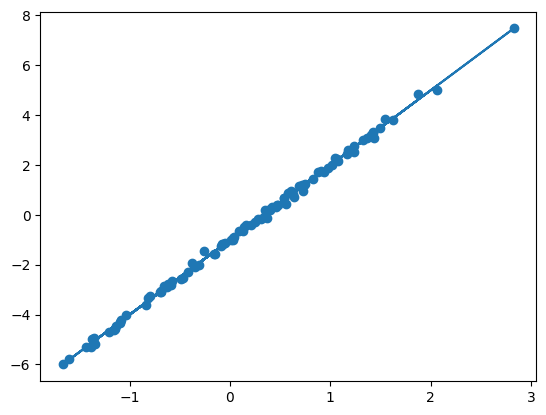

In [30]:
plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")